# Feature Engineering

En este _notebook_ vamos a explorar varias técnicas para manejar _features_. El proceso de trabajar nuestros _datasets_ es muy importante para mejorar el desempeño de nuestros modelos. Por ejemplo, en general los modelos no están pensados para trabajar con variables de tipo texto (por ejemplo, una categoría). De la misma forma, hay modelos que son afectados por la escala de los datos (por ejemplo K-means o SVM). En este _notebook_ vamos a presentar algunas de las técnicas más famosas para procesar nuestros datos.

## Tipos de datos

Como sabemos, las columnas de un _dataset_ pueden tener varios tipos de datos. Es importante conocer los posibles tipos de datos para entender las posibles formas de procesarlos.

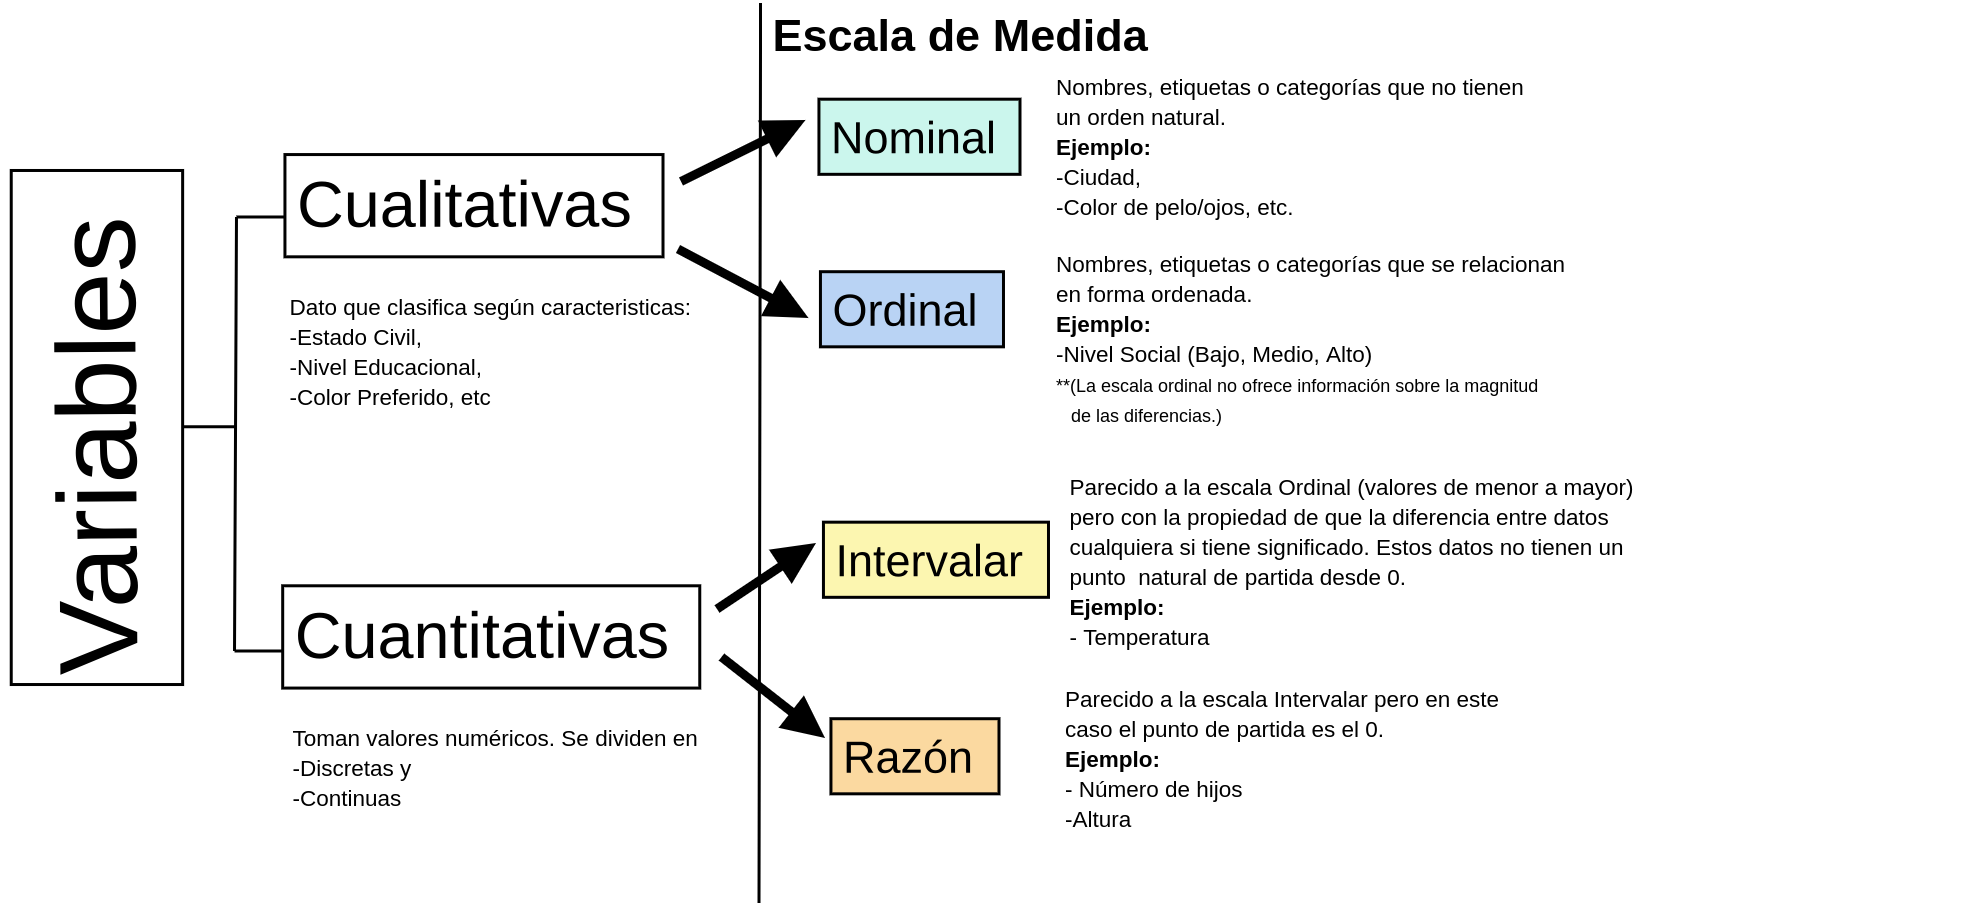

## Imputación

La primera técnica que vamos a discutir es la de imputación. Imputación hace referencia a asignar un valor concreto a los **valores nulos**. Para hacer esto existen varias técnicas. Por ejemplo, hay muchas veces que un valor nulo podemos entenderlo como la no existencia de valor. En este caso, a veces es razonable reemplazar con un 0. En otros casos, una columna puede tener más valores nulos que valores concretos, por lo que podríamos considerar borrar esa columna. 

Para ver ejemplos concretos carguemos los datos del presupuesto comunal.

In [31]:
import pandas as pd
import numpy as np

df_presupuesto = pd.read_csv("presupuesto_2019.csv", delimiter=';')

# Reemplazamos los no recepcionados por pd.nan, que se transformará en un NaN
df_presupuesto = df_presupuesto.replace("No Recepcionado", np.nan)

# Le pedimos a pandas que lea la columna como una columna numérica
df_presupuesto["PRESUPUESTO"] = pd.to_numeric(df_presupuesto["PRESUPUESTO"], errors="coerce")
df_presupuesto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CODIGO       345 non-null    int64  
 1   MUNICIPIO    345 non-null    object 
 2   PRESUPUESTO  343 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.2+ KB


Veamos los valores nulos.

In [32]:
df_presupuesto[df_presupuesto["PRESUPUESTO"].isnull()]

,CODIGO,MUNICIPIO,PRESUPUESTO
63,5602,ALGARROBO,NaN
87,6110,MOSTAZAL,NaN


Para saber el porcentaje de valores nulos hacemos lo siguiente

In [33]:
df_presupuesto.isnull().mean()

CODIGO         0.000000
MUNICIPIO      0.000000
PRESUPUESTO    0.005797
dtype: float64

Como vemos, hay un $0.5\%$ de valores nulos, lo que es aceptable. Ahora veamos dos formas clásicas de manejar los valores nulos.

In [39]:
# Para borrar las filas con nulos
df_presupuesto_drop = df_presupuesto.dropna(0)

df_presupuesto_drop[df_presupuesto_drop["MUNICIPIO"] == "ALGARROBO"]

,CODIGO,MUNICIPIO,PRESUPUESTO


In [40]:
# Para reemplazar por 0
df_presupuesto_fill_0 = df_presupuesto.fillna(0)

df_presupuesto_fill_0[df_presupuesto_fill_0["MUNICIPIO"] == "ALGARROBO"]

,CODIGO,MUNICIPIO,PRESUPUESTO
63,5602,ALGARROBO,0.0


Ahora, ¿es razonable reemplazar el valor `NaN` por 0? En esta caso, un valor nulo no representa "auscencia de valor", sino que representa un "desconocido". Por lo mismo, vamos a ver otra técnica, que es reemplazar por una medida estadística.

In [41]:
# Reemplazar los nulos de cada columna por la mediana de dicha columna
df_presupuesto_fill_median = df_presupuesto.fillna(df_presupuesto.median())

df_presupuesto_fill_median[df_presupuesto_fill_median["MUNICIPIO"] == "ALGARROBO"]

,CODIGO,MUNICIPIO,PRESUPUESTO
63,5602,ALGARROBO,5394372.0


¿Por qué reemplazamos por la mediana? Esto es porque no queremos un valor que mantenga la "forma" de nuestros datos. En general uno prefiere la mediana por sobre el promedio porque es **menos sensible a los _outliers_**. Además, en este caso, podemos reemplazar por la mediana del presupuesto sujeto a la región a la que pertenece cada comuna, ya que podemos entender que en cada región el presupuesto funciona distinto. ¿Cómo harías esto?

Recuerda que hay todo un tópico sobre imputación, pero lo que vimos acá son las estrategias más estándar.

## Revisión de _outliers_

Otro trabajo de preprocesamiento común es la detección y manejo de _outliers_. Vamos a ver dos _approaches_. La primera basada en buscar datos por desviación estándar y otra por cuantiles. Partamos por la primera.

In [44]:
num_of_sigma = 2

# Calculamos el valor del presupuesto 2 sigma más allá del promedio
upper_limit = (
    df_presupuesto_fill_median["PRESUPUESTO"].mean() + 
    df_presupuesto_fill_median["PRESUPUESTO"].std() * num_of_sigma
)

# Calculamos el valor del presupuesto 2 sigma más atrás del promedio
lower_limit = (
    df_presupuesto_fill_median["PRESUPUESTO"].mean() - 
    df_presupuesto_fill_median["PRESUPUESTO"].std() * num_of_sigma
)

In [48]:
df_presupuesto_fill_median["PRESUPUESTO"].mean()

14165339.24057971

In [47]:
df_presupuesto_fill_median["PRESUPUESTO"].std()

27390162.80733765

In [45]:
upper_limit

68945664.85525501

In [46]:
lower_limit

-40614986.37409559

In [51]:
# Para filtrar los datos fuera de ese rango
# Este nuevo DataFrame lo podríamos asignar a una variable
df_presupuesto_fill_median[(df_presupuesto_fill_median["PRESUPUESTO"] < upper_limit) & 
                           (df_presupuesto_fill_median["PRESUPUESTO"] > lower_limit)]

,CODIGO,MUNICIPIO,PRESUPUESTO
0,1101,IQUIQUE,59072234.0
1,1107,ALTO HOSPICIO,13984411.0
2,1401,POZO ALMONTE,7613962.0
3,1402,CAMIÑA,1584008.0
4,1403,COLCHANE,2500000.0
...,...,...,...
340,16301,SAN CARLOS,10459691.0
341,16302,COIHUECO,5001190.0
342,16303,ÑIQUÉN,3386698.0
343,16304,SAN FABIÁN,1798500.0


Ahora veamos el _approach_ basado en cuantiles, que es bastante similar.

In [53]:
upper_limit = df_presupuesto_fill_median['PRESUPUESTO'].quantile(.95)
lower_limit = df_presupuesto_fill_median['PRESUPUESTO'].quantile(.05)

In [54]:
upper_limit

56586308.2

In [55]:
lower_limit

2080341.4000000001

In [56]:
# Para filtrar los datos fuera de este nuevo rango
# Este nuevo DataFrame lo podríamos asignar a una variable
df_presupuesto_fill_median[(df_presupuesto_fill_median["PRESUPUESTO"] < upper_limit) & 
                           (df_presupuesto_fill_median["PRESUPUESTO"] > lower_limit)]

,CODIGO,MUNICIPIO,PRESUPUESTO
1,1107,ALTO HOSPICIO,13984411.0
2,1401,POZO ALMONTE,7613962.0
4,1403,COLCHANE,2500000.0
5,1404,HUARA,3950000.0
6,1405,PICA,5887820.0
...,...,...,...
339,16207,TREHUACO,2120717.0
340,16301,SAN CARLOS,10459691.0
341,16302,COIHUECO,5001190.0
342,16303,ÑIQUÉN,3386698.0


Ahora bien, además de eliminar, podemos asignar un valor defecto a todas las filas que no estén en ese rango. Por ejemplo, todas las comunas con presupuesto por sobre el `upper_limit` pueden tener el valor `upper_limit`, y podemos hacer algo análogo con el `lower_limit`. Vamos a ver cómo hacer esto

In [61]:
upper_limit = df_presupuesto_fill_median['PRESUPUESTO'].quantile(.95)
lower_limit = df_presupuesto_fill_median['PRESUPUESTO'].quantile(.05)

df_copy = df_presupuesto_fill_median.copy()
df_copy.loc[df_copy["PRESUPUESTO"] > upper_limit, "PRESUPUESTO"] = upper_limit
df_copy.loc[df_copy["PRESUPUESTO"] < lower_limit, "PRESUPUESTO"] = lower_limit

In [62]:
df_copy

,CODIGO,MUNICIPIO,PRESUPUESTO
0,1101,IQUIQUE,56586308.2
1,1107,ALTO HOSPICIO,13984411.0
2,1401,POZO ALMONTE,7613962.0
3,1402,CAMIÑA,2080341.4
4,1403,COLCHANE,2500000.0
...,...,...,...
340,16301,SAN CARLOS,10459691.0
341,16302,COIHUECO,5001190.0
342,16303,ÑIQUÉN,3386698.0
343,16304,SAN FABIÁN,2080341.4


In [63]:
# Veamos las filas que fueron cambiadas
df_copy[df_copy["PRESUPUESTO"] == upper_limit]

,CODIGO,MUNICIPIO,PRESUPUESTO
0,1101,IQUIQUE,56586308.2
7,2101,ANTOFAGASTA,56586308.2
25,4101,LA SERENA,56586308.2
26,4102,COQUIMBO,56586308.2
40,5101,VALPARAÍSO,56586308.2
46,5109,VIÑA DEL MAR,56586308.2
174,9101,TEMUCO,56586308.2
256,13101,SANTIAGO,56586308.2
265,13110,LA FLORIDA,56586308.2
269,13114,LAS CONDES,56586308.2


In [64]:
# Veamos las filas que fueron cambiadas
df_copy[df_copy["PRESUPUESTO"] == lower_limit]

,CODIGO,MUNICIPIO,PRESUPUESTO
3,1402,CAMIÑA,2080341.4
43,5104,JUAN FERNÁNDEZ,2080341.4
167,8308,QUILACO,2080341.4
169,8310,SAN ROSENDO,2080341.4
235,10404,PALENA,2080341.4
237,11102,LAGO VERDE,2080341.4
240,11203,GUAITECAS,2080341.4
242,11302,O´HIGGINS,2080341.4
243,11303,TORTEL,2080341.4
247,12102,LAGUNA BLANCA,2080341.4


Cambiar estos valores hace que la distribución de los datos cambie. Si bien puede tener resultados positivos en el desempeño de un modelo, hay que usar esta estrategia con precaución.

# _Scaling_

Supongamos que tenemos un dataset con dos columnas numéricas, una que representa la edad de una persona y otra que representa el salario. En la práctica, ambos números van a tener una escala muy distinta y eso puede afectar el desempeño de algunos algoritmos (en especial los basados en distancia). Por lo mismo, a veces queremos escalar la columna. Tenemos dos opciones:

- Normalización: normalizar una columna donde cada valor $x_i$ se escala según el mínimo y el máximo:

$$
x_i^{\text{normalizado}} = \frac{x_i - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}
$$

- Estandarización: escalar cada valor $x_i$ de una columna según su media $\mu$ y su desviación estándar $\sigma$.

$$
x_i^{\text{estandarizado}} = \frac{x_i - \mu}{\sigma}
$$

Escalar valores es importante para los modelos basados en distancia, como KNN, K-Means, SVM y PCA. Es importante tener presente esto al momento de usar algún modelo en la práctica. Vamos a ver un ejemplo con los datos de presupuesto.

In [68]:
# Normalizar con MinMax
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_presupuesto_fill_median[['PRESUPUESTO']])
df_minmax = scaler.transform(df_presupuesto_fill_median[['PRESUPUESTO']])
df_minmax

array([[1.70522548e-01],
       [3.73853511e-02],
       [1.85744246e-02],
       [7.68925845e-04],
       [3.47370508e-03],
       [7.75532533e-03],
       [1.34774007e-02],
       [2.93251702e-01],
       [2.37866919e-02],
       [2.02581466e-02],
       [1.69264762e-02],
       [1.32548572e-01],
       [3.95607242e-03],
       [1.76299080e-02],
       [1.20442066e-02],
       [8.73968459e-03],
       [8.33300921e-02],
       [2.30424075e-02],
       [1.42433088e-02],
       [9.18999292e-03],
       [1.46481670e-02],
       [2.29824412e-02],
       [5.88963441e-03],
       [4.94710510e-03],
       [7.74489589e-03],
       [1.70964783e-01],
       [1.63870269e-01],
       [6.68150973e-03],
       [8.16978617e-03],
       [1.02061838e-02],
       [1.99189891e-02],
       [1.46936171e-02],
       [4.95012586e-03],
       [1.70683838e-02],
       [3.37943296e-02],
       [6.02030916e-02],
       [5.27699065e-03],
       [1.58207374e-02],
       [5.89025155e-03],
       [2.26392590e-03],


Y si queremos estandarizar.

In [69]:
# Normalizar con StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_presupuesto_fill_median[['PRESUPUESTO']])
df_minmax = scaler.transform(df_presupuesto_fill_median[['PRESUPUESTO']])
df_minmax

array([[ 1.64190769e+00],
       [-6.61518619e-03],
       [-2.39534636e-01],
       [-4.60004742e-01],
       [-4.26513798e-01],
       [-3.73498194e-01],
       [-3.02646678e-01],
       [ 3.16155677e+00],
       [-1.74995633e-01],
       [-2.18686561e-01],
       [-2.59939757e-01],
       [ 1.17170875e+00],
       [-4.20541060e-01],
       [-2.51229769e-01],
       [-3.20392683e-01],
       [-3.61309724e-01],
       [ 5.62278845e-01],
       [-1.84211464e-01],
       [-2.93163101e-01],
       [-3.55733945e-01],
       [-2.88150091e-01],
       [-1.84953975e-01],
       [-3.96599433e-01],
       [-4.08269959e-01],
       [-3.73627333e-01],
       [ 1.64738351e+00],
       [ 1.55953826e+00],
       [-3.86794325e-01],
       [-3.68366284e-01],
       [-3.43151331e-01],
       [-2.22886055e-01],
       [-2.87587322e-01],
       [-4.08232555e-01],
       [-2.58182637e-01],
       [-5.10797024e-02],
       [ 2.75917180e-01],
       [-4.04185271e-01],
       [-2.73631165e-01],
       [-3.9

## Log Transform

Hacer _Log Transform_ de una columna es una de las transformaciones más comunes en el contexto de _feature engineering_. Esto porque entre otras cosas:

- Ayuda a menjar datos sesgados, ya que después de la transformación se ven más como una distribución normal.
- Ayuda a manejar el efecto de los _outliers_.

La idea es aplicar la función logaritmo a **todos los elementos de una columna**, pero ojo, ya que los datos deben ser positivos. Además, en general, para evitar valores negativos aplicamos $log(x+1)$.

In [70]:
log_column = (df_presupuesto_fill_median["PRESUPUESTO"] + 1).transform(np.log)
log_column

0      17.894272
1      16.453454
2      15.845494
3      14.275470
4      14.731802
         ...    
340    16.163040
341    15.425187
342    15.035366
343    14.402464
344    15.196717
Name: PRESUPUESTO, Length: 345, dtype: float64

## Binning

La idea de hacer Binning es principalmente manejar las variables categóricas con valores que aparecen pocas veces ya que pueden producir _overfitting_. La idea es agrupar los valores que aparecen poco en una nueva categoría como `"Otros"`. Al hacer esto estamos perdiendo información, pero existe la posibilidad de que podamos generalizar mejor. Esto se puede hacer para columnas numéricas, por ejemplo agrupando las etiquetas por ciertos intervalos. Veamos un ejemplo.

In [71]:
import pandas as pd

# Vamos a calcular 10 bins que tienen el mismo "ancho"
bins_presupuesto = pd.cut(df_presupuesto_fill_median["PRESUPUESTO"], bins=10)
bins_presupuesto

0      (35189290.4, 69054974.8]
1      (984949.156, 35189290.4]
2      (984949.156, 35189290.4]
3      (984949.156, 35189290.4]
4      (984949.156, 35189290.4]
                 ...           
340    (984949.156, 35189290.4]
341    (984949.156, 35189290.4]
342    (984949.156, 35189290.4]
343    (984949.156, 35189290.4]
344    (984949.156, 35189290.4]
Name: PRESUPUESTO, Length: 345, dtype: category
Categories (10, interval[float64]): [(984949.156, 35189290.4] < (35189290.4, 69054974.8] < (69054974.8, 102920659.2] < (102920659.2, 136786343.6] ... (204517712.4, 238383396.8] < (238383396.8, 272249081.2] < (272249081.2, 306114765.6] < (306114765.6, 339980450.0]]

Notamos que genera una columna nueva, que podemos asignar al DataFrame antiguo, que dice el intervalo (bin) al que pertenece cada observación. Para agregarla al DataFrame.

In [72]:
df_bin = df_presupuesto_fill_median.copy()
df_bin["bins presupuesto"] = pd.cut(df_presupuesto_fill_median["PRESUPUESTO"], bins=10)
df_bin

,CODIGO,MUNICIPIO,PRESUPUESTO,bins presupuesto
0,1101,IQUIQUE,59072234.0,"(35189290.4, 69054974.8]"
1,1107,ALTO HOSPICIO,13984411.0,"(984949.156, 35189290.4]"
2,1401,POZO ALMONTE,7613962.0,"(984949.156, 35189290.4]"
3,1402,CAMIÑA,1584008.0,"(984949.156, 35189290.4]"
4,1403,COLCHANE,2500000.0,"(984949.156, 35189290.4]"
...,...,...,...,...
340,16301,SAN CARLOS,10459691.0,"(984949.156, 35189290.4]"
341,16302,COIHUECO,5001190.0,"(984949.156, 35189290.4]"
342,16303,ÑIQUÉN,3386698.0,"(984949.156, 35189290.4]"
343,16304,SAN FABIÁN,1798500.0,"(984949.156, 35189290.4]"


Y podemos hacer un histograma.

<AxesSubplot:>

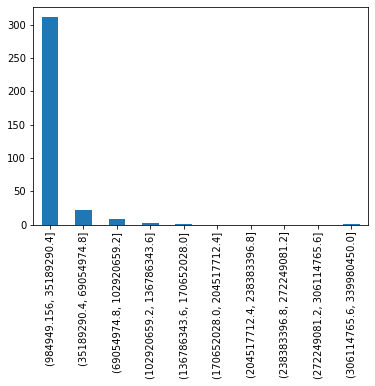

In [76]:
df_bin["bins presupuesto"].value_counts(sort=False).plot(kind='bar')

O un boxplot.

<AxesSubplot:>

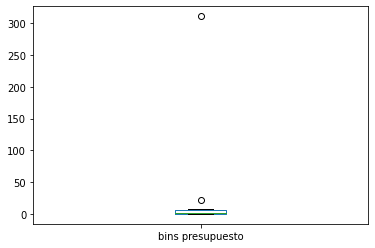

In [79]:
df_bin["bins presupuesto"].value_counts(sort=False).plot(kind='box')

Como vemos, esto no muestra mucho por lo sesgado de los datos. ¿Qué pasa cuando usamos _log transform_?

<AxesSubplot:>

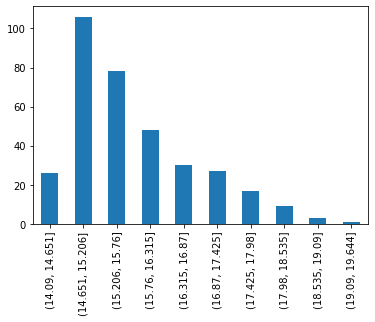

In [83]:
pd.cut(log_column, bins=10).value_counts(sort=False).plot(kind='bar')

<AxesSubplot:>

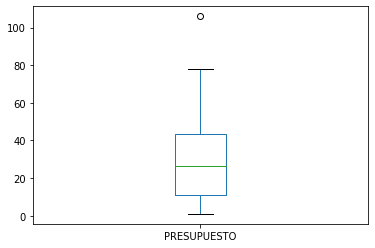

In [81]:
pd.cut(log_column, bins=10).value_counts(sort=False).plot(kind='box')

Como vemos, se ve mucho mejor. Finalmente, podemos crear bins de tamaño _custom_. Vamos a ver un ejemplo más sencillo.

In [84]:
data = pd.DataFrame({'value': [2, 43, 10, 85, 28]})
data

,value
0,2
1,43
2,10
3,85
4,28


Ahora, amos a crear tres intervalos:

- De 0 a 30
- De 30 a 70
- De 70 a 100

In [8]:
data['value_2'] = pd.cut(data['value'], bins=[0,30,70,100], labels=["Low", "Mid", "High"])
data

,value,value_2
0,2,Low
1,43,Mid
2,10,Low
3,85,High
4,28,Low


## One Hot Encoding

Este método cambia los valores **categóricos nominales** por valores numéricos. ¿Pero por qué solamente los nominales?

Imaginemos que tenemos una variable **categórica ordinal**, es decir, se puede inferir un orden: por ejemplo, una etiqueta que puede ser bajo, medio, alto. En este caso, podemos reemplazar los valores respectivamente por 0, 1 y 2. esto porque hay un orden que un programa podría querer aprender sobre los datos.

Ahora bien, para las variables **categóricas nominales**, no hay un orden para los valores, así que no queremos que un modelo aprenda algo de este estilo. Al usar _one hot encoding_ el modelo no va a "aprender" que existe una relación de orden entre los distintos valores de la columna que estamos serializando. Para aprender esta técnica lo mejor es partir con el ejemplo.

In [85]:
data = pd.DataFrame(
    {
        'nombre': ["Alice", "Bob", "Charles", "Dino", "Edward"],
        'color favorito': ["Naranjo", "Azul", "Naranjo", "Rojo", "Verde"]
    }
)
data

,nombre,color favorito
0,Alice,Naranjo
1,Bob,Azul
2,Charles,Naranjo
3,Dino,Rojo
4,Edward,Verde


In [87]:
import pandas as pd

# Ahora hacemos One Hot Encoding
one_hot = pd.get_dummies(data["color favorito"])
one_hot

,Azul,Naranjo,Rojo,Verde
0,0,1,0,0
1,1,0,0,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,1


Vemos que se genera una columna por cada valor variable categórica. Cada fila tiene un 1 en la columna que le corresponde. Ahora hay que juntar esto con los datos.

In [90]:
# .join sirve para hacer merge sobre los índices
# .drop elimina filas con axis=0, columnas con axis=1
data = data.join(one_hot).drop("color favorito", axis=1)
data

,nombre,Azul,Naranjo,Rojo,Verde
0,Alice,0,1,0,0
1,Bob,1,0,0,0
2,Charles,0,1,0,0
3,Dino,0,0,1,0
4,Edward,0,0,0,1


## Fechas

Manejar fechas es un tema muy complejo en el área de _Machine Learning_. Hay muchas formas de trabajar este tipo de dato, como por ejemplo:

1. Extraer las partes de la fecha (mes, día, año).
2. Extraer el periodo de tiempo entre la fecha actual y la fecha del _dataset_.
3. Extraer un valor específico, por ejemplo: el día de la semana, el mes del año, estación, etc. Luego de esto es necesario hacer un trabajo de variables categóricas.

In [91]:
from datetime import date

data = pd.DataFrame(
    {
        'date':
            [
                '18-09-2016',
                '04-12-2006',
                '14-06-1974',
                '24-08-1999',
                '20-02-2000',
            ]
    }
)

# Transformamos la fecha a tipo dato
data["date"] = pd.to_datetime(data["date"], format="%d-%m-%Y")

# Extraemos el año y lo guardamos en una nueva columna
data["year"] = data["date"].dt.year

# Hacemos lo mismo con el mes
data["month"] = data["date"].dt.month

# Extraemos la diferencia entre los años de la fecha del dataset y la fecha actual
data["passed_years"] = date.today().year - data["date"].dt.year

# Extraemos el día de la semana
data["day_name"] = data["date"].dt.day_name()

In [92]:
data

,date,year,month,passed_years,day_name
0,2016-09-18,2016,9,5,Sunday
1,2006-12-04,2006,12,15,Monday
2,1974-06-14,1974,6,47,Friday
3,1999-08-24,1999,8,22,Tuesday
4,2000-02-20,2000,2,21,Sunday


## Palabras al cierre

Este es un repaso de las técnicas más populares del tópico de _feature engineering_. Por supuesto, hay muchas formas de seguir con este tema, como entender técnicas más complejas de imputación, otros tipos de escalamiento, otras técnicas para transformar datos categóricos y para el manejo de fechas. Además, hay varias cosas que se aprenden después de haber pasado por ciertas desafíos, por lo que una buena idea es poner manos en el código, así que a partir de ahora, puedes buscar otras referencias para continuar en el tema.

**Este _notebook_ está inspirado [en el siguiente post](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114#3abe).**